In [1]:
!ls

analyze_strength.py	docker_kaggle		__pycache__
analyze_strength_ts.py	graphs			README.md
atp-matches-dataset	model_strength.stan	result_strength.pickle
df_matches.csv		model_strength_ts.stan	result_strength_ts.pickle
docker			notebook.ipynb
docker_anaconda		preprocess.py


In [106]:
import numpy as np
import pandas as pd

import pystan
import pickle
SEED = 2019

import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

In [87]:
years = list(range(2005,2018)) # use data 2005--2017
df_matches = pd.concat([pd.read_csv('../tennis_atp/atp_matches_'+str(y)+'.csv', usecols=[5,10,20]) for y in years]) # 5: tourney_date, 10: winner_name, 20: loser_name
df_matches = df_matches.dropna(subset=['tourney_date'])
df_matches['year'] = df_matches['tourney_date'].apply(lambda x: int(str(x)[0:4]))
df_matches['date'] = pd.to_datetime(df_matches['tourney_date'].apply(lambda x: str(x)[0:8]))
df_matches[df_matches['date'] < '2017-03']
#df_matches['month'] = df_matches['tourney_date'].apply(lambda x: int(str(x)[4:6]))
#df_matches['day'] = df_matches['tourney_date'].apply(lambda x: int(str(x)[6:8]))
#df_matches = df_matches[['year', 'month', 'day', 'winner_name', 'loser_name']]
df_matches = df_matches[['year', 'winner_name', 'loser_name']]
df_matches.to_csv('./df_matches.csv', header=True, index=False)
df_matches.shape

(39608, 3)

In [88]:
# read data
df_matches = pd.read_csv('./df_matches.csv')

In [157]:
# target player
arr_target_player = np.array([
    'Roger Federer', 'Rafael Nadal', 'Novak Djokovic', 'Andy Murray', 'Stanislas Wawrinka', 'Juan Martin Del Potro',
    'Milos Raonic', 'Kei Nishikori', 'Gael Monfils', 'Tomas Berdych', 'Jo Wilfried Tsonga', 'David Ferrer',
    'Richard Gasquet', 'Marin Cilic', 'Grigor Dimitrov', 'Dominic Thiem', 'Nick Kyrgios', 'Alexander Zverev'
])

In [158]:
# create data for modeling

In [159]:
dic_target_player = {}

for player in arr_target_player:
    if player not in dic_target_player:
        dic_target_player[player] = len(dic_target_player)+1

In [92]:
LW = []

for player_a in arr_target_player:
    for player_b in arr_target_player:
        
        df_tmp = df_matches[
            (df_matches['year'] >= 2015) &
            (df_matches['winner_name'] == player_a) &
            (df_matches['loser_name'] == player_b)
        ]
        
        for _ in range(len(df_tmp)):
            
            LW.append([dic_target_player[player_b], dic_target_player[player_a]])
            
        df_tmp = df_matches[
            (df_matches['year'] >= 2015) &
            (df_matches['winner_name'] == player_b) &
            (df_matches['loser_name'] == player_a)
        ]
        
        for _ in range(len(df_tmp)):
            
            LW.append([dic_target_player[player_a], dic_target_player[player_b]])

LW = np.array(LW, dtype=np.int32)
LW.shape

(934, 2)

In [93]:
# estimate
sm = pystan.StanModel(file='./model_strength.stan')
fit = sm.sampling(data={'N': len(dic_target_player), 'G': len(LW), 'LW': LW}, iter=1000, chains=4, seed=SEED)
la = fit.extract()
with open('./result_strength.pickle', mode='wb') as f:
    pickle.dump(la, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8bc3da4da00965b5451a30c45bbfb557 NOW.


In [162]:
with open('./result_strength.pickle', mode='rb') as f:
    la = pickle.load(f)

In [95]:
# output graphs

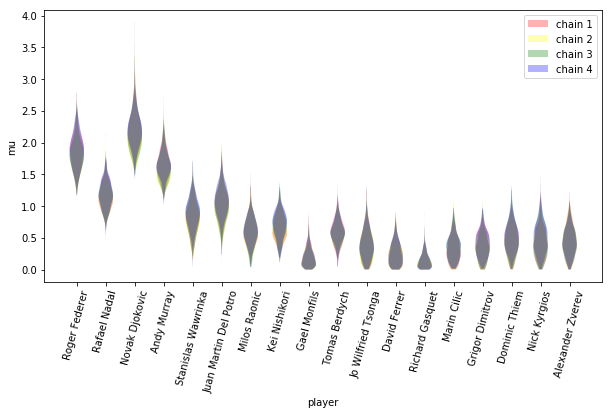

<Figure size 432x288 with 0 Axes>

In [101]:
# violinplot strength mu chains

plt.figure(figsize=(10,5))

colors = ['red', 'yellow', 'green', 'blue']

for i, player in enumerate(arr_target_player):
    for j in range(4):
        
        g = plt.violinplot(la['mu'][j*500:(j+1)*500, i], positions=[i], showmeans=False, showextrema=False, showmedians=False)
        
        for pc in g['bodies']:
            pc.set_facecolor(colors[j])

plt.legend(['chain 1', 'chain 2', 'chain 3', 'chain 4'])

plt.xticks(list(range(len(arr_target_player))), arr_target_player)
plt.xticks(rotation=75)

plt.xlabel('player')
plt.ylabel('mu')
plt.show()
plt.savefig('./graphs/strength_mu_chains.png', bbox_inches='tight')

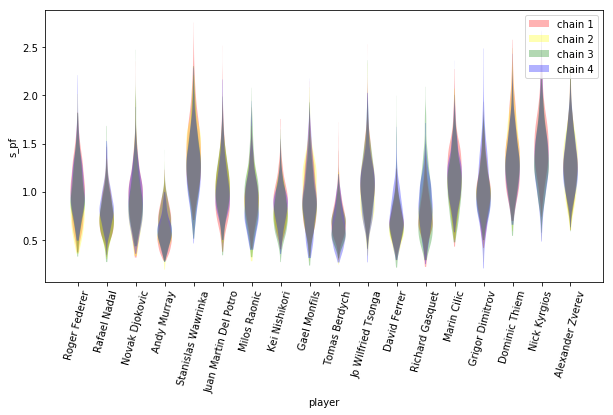

<Figure size 432x288 with 0 Axes>

In [100]:
# violinplot strength s_pf chains

plt.figure(figsize=(10,5))

for i, player in enumerate(arr_target_player):
    for j in range(4):
        
        g = plt.violinplot(la['s_pf'][j*500:(j+1)*500, i], positions=[i], showmeans=False, showextrema=False, showmedians=False)

        for pc in g['bodies']:
            pc.set_facecolor(colors[j])

plt.legend(['chain 1', 'chain 2', 'chain 3', 'chain 4'])

plt.xticks(list(range(len(arr_target_player))), arr_target_player)
plt.xticks(rotation=75)

plt.xlabel('player')
plt.ylabel('s_pf')
plt.show()
plt.savefig('./graphs/strength_s_pf_chains.png', bbox_inches='tight')

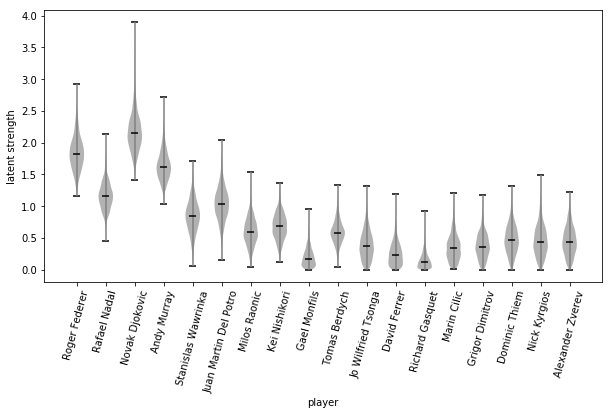

<Figure size 432x288 with 0 Axes>

In [167]:
# violinplot strength mu

plt.figure(figsize=(10,5))

for i, player in enumerate(arr_target_player):

    g = plt.violinplot(la['mu'][:, i], positions=[i], showmeans=False, showextrema=True, showmedians=True)
    
    for pc in g['bodies']:
        pc.set_facecolor('black')

    g['cbars'].set_edgecolor('gray')
    g['cmaxes'].set_edgecolor('black')
    g['cmedians'].set_edgecolor('black')
    g['cmins'].set_edgecolor('black')

plt.xticks(list(range(len(arr_target_player))), arr_target_player)
plt.xticks(rotation=75)

plt.xlabel('player')
plt.ylabel('latent strength')
plt.show()
plt.savefig('./graphs/strength_mu.png', bbox_inches='tight')

In [ ]:
168   # table strength mu
169   """
170   cm = generate_cmap(['white', 'violet'])
171 
172   summary = np.zeros((len(arr_target_player), 4))
173 
174   for i, player in enumerate(arr_target_player):
175     
176     samples = la['mu'][:, i]
177 
178     median = np.median(samples, axis=0)
179     std = np.std(samples, ddof=1)
180     lower, upper = np.percentile(samples, q=[25.0, 75.0], axis=0)
181     
182     summary[i] = [median, std, lower, upper]
183     
184   summary = pd.DataFrame(summary, index=arr_target_player, columns=['median', 'std', '25%', '75%'])
185   summary.style.background_gradient(cmap=cm, axis=0)
186   with open('./graphs/strength_mu_tb.pickle', mode='wb') as f:
187     pickle.dump(summary, f)
188   #html = summary.render()
189   #imgkit.from_string(html, './graphs/strength_mu_tb.png')
190   """

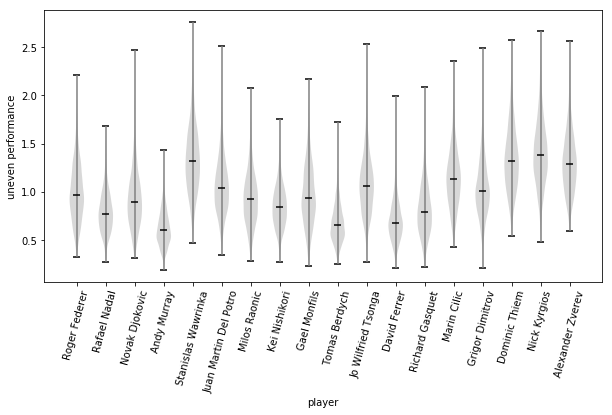

<Figure size 432x288 with 0 Axes>

In [168]:
# violinplot strength s_pf

plt.figure(figsize=(10,5))

for i, player in enumerate(arr_target_player):
    
    g = plt.violinplot(la['s_pf'][:, i], positions=[i], showmeans=False, showextrema=True, showmedians=True)

    for pc in g['bodies']:
        pc.set_facecolor('gray')

    g['cbars'].set_edgecolor('gray')
    g['cmaxes'].set_edgecolor('black')
    g['cmedians'].set_edgecolor('black')
    g['cmins'].set_edgecolor('black')

plt.xticks(list(range(len(arr_target_player))), arr_target_player)
plt.xticks(rotation=75)

plt.xlabel('player')
plt.ylabel('uneven performance')
plt.show()
plt.savefig('./graphs/strength_s_pf.png', bbox_inches='tight')

In [ ]:
# table strength s_pf
"""
cm = generate_cmap(['white', 'violet'])

summary = np.zeros((len(arr_target_player), 4))

for i, player in enumerate(arr_target_player):
    
    samples = la['s_pf'][:, i]
    
    median = np.median(samples, axis=0)
    std = np.std(samples, ddof=1)
    lower, upper = np.percentile(samples, q=[25.0, 75.0], axis=0)

    summary[i] = [median, std, lower, upper]
    
summary = pd.DataFrame(summary, index=arr_target_player, columns=['median', 'std', '25%', '75%'])
summary.style.background_gradient(cmap=cm, axis=0)
with open('./graphs/strength_s_pf_tb.pickle', mode='wb') as f:
    pickle.dump(summary, f)
#html = summary.render()
#imgkit.from_string(html, './graphs/strength_s_pf_tb.png')
"""

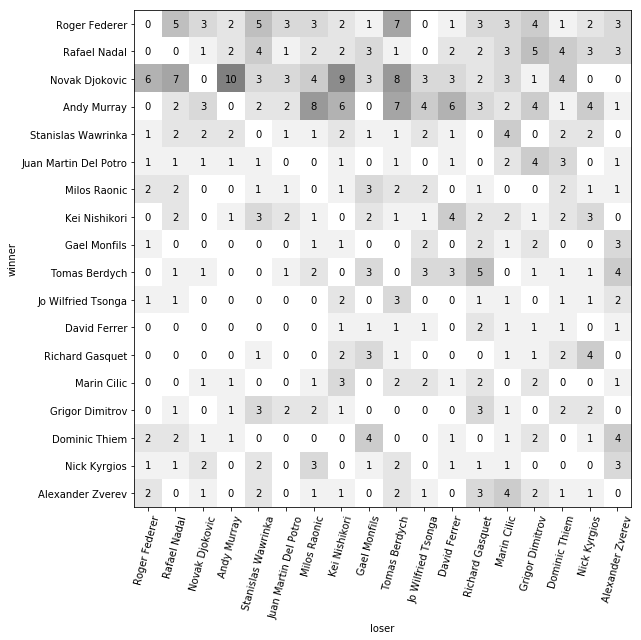

In [169]:
# crostab win-lose

def generate_cmap(colors):
    
    values = range(len(colors))
    vmax = np.ceil(np.max(values))
    color_list = []
    
    for v, c in zip(values, colors):
        color_list.append((v/vmax,c))
        
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

cm = generate_cmap(['white', 'gray'])

df_tmp = df_matches[
    (df_matches['year'] >= 2015) &
    (df_matches['winner_name'].isin(arr_target_player)) &
    (df_matches['loser_name'].isin(arr_target_player))
]

summary = np.zeros((len(arr_target_player), len(arr_target_player)), dtype=np.int32)

for i in range(len(arr_target_player)):
    for j in range(i+1, len(arr_target_player)):
        
        summary[i, j] = len(df_tmp[
            (df_tmp['winner_name'] == arr_target_player[i]) &
            (df_tmp['loser_name'] == arr_target_player[j])
        ])
        
        summary[j, i] = len(df_tmp[
            (df_tmp['loser_name'] == arr_target_player[i]) &
            (df_tmp['winner_name'] == arr_target_player[j])
        ])

fig, axs = plt.subplots(figsize=(9, 9))
im = axs.imshow(summary, cmap=cm, interpolation='nearest')

axs.grid(False)
axs.set_xticks(list(range(len(arr_target_player))))
axs.set_yticks(list(range(len(arr_target_player))))
axs.set_xticklabels(arr_target_player)
axs.set_yticklabels(arr_target_player)
axs.set_ylabel('winner')
axs.set_xlabel('loser')

for tick in axs.get_xticklabels():
    tick.set_rotation(75)

for i in range(len(arr_target_player)):
    for j in range(len(arr_target_player)):
        text = axs.text(j, i, summary[i, j], ha='center', va='center', color='black')

fig.tight_layout()
plt.savefig('./graphs/strength_winlose_crosstab.png', bbox_inches='tight')

In [113]:
arr_target_player = np.array([
    'Roger Federer', 'Rafael Nadal', 'Novak Djokovic',
    'Andy Murray', 'Stanislas Wawrinka', 'Juan Martin Del Potro',
    'Kei Nishikori', 'Tomas Berdych', 'David Ferrer'
])

arr_target_year = np.array(list(range(2005, 2017))) # 2005--2016

In [134]:
dic_target_year = {}

for year in arr_target_year:
    if year not in dic_target_year:
        dic_target_year[year] = len(dic_target_year)+1

dic_target_player = {}

for player in arr_target_player:
    if player not in dic_target_player:
        dic_target_player[player] = len(dic_target_player)+1

LW = []
GY = []

for year in arr_target_year:
    for player_a in arr_target_player:
        for player_b in arr_target_player:

            df_tmp = df_matches[
                (df_matches['year'] == year) &
                (df_matches['winner_name'] == player_a) &
                (df_matches['loser_name'] == player_b)
            ]
            
            for _ in range(len(df_tmp)):
                
                LW.append([dic_target_player[player_b], dic_target_player[player_a]])
                GY.append(dic_target_year[year])
                
            df_tmp = df_matches[
                (df_matches['year'] == year) &
                (df_matches['winner_name'] == player_b) &
                (df_matches['loser_name'] == player_a)
            ]
            
            for _ in range(len(df_tmp)):
                
                LW.append([dic_target_player[player_a], dic_target_player[player_b]])
                GY.append(dic_target_year[year])
                
LW = np.array(LW, dtype=np.int32)
GY = np.array(GY, dtype=np.int32)
LW.shape, GY.shape

((1320, 2), (1320,))

In [71]:
data = {
    'N': len(dic_target_player),
    'G': len(LW),
    'Y': len(dic_target_year),
    'GY': GY,
    'LW': LW,
}
sm = pystan.StanModel(file='./model_strength_ts.stan')
fit = sm.sampling(data=data, iter=5000, chains=4, seed=SEED)
la = fit.extract()
with open('./result_strength_ts.pickle', mode='wb') as f:
    pickle.dump(la, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fde0244bca0f1943eefeff1ca69001b0 NOW.


In [114]:
with open('./result_strength_ts.pickle', mode='rb') as f:
    la = pickle.load(f)

In [136]:
dic_target_player

{'Roger Federer': 1,
 'Rafael Nadal': 2,
 'Novak Djokovic': 3,
 'Andy Murray': 4,
 'Stanislas Wawrinka': 5,
 'Juan Martin Del Potro': 6,
 'Kei Nishikori': 7,
 'Tomas Berdych': 8,
 'David Ferrer': 9}

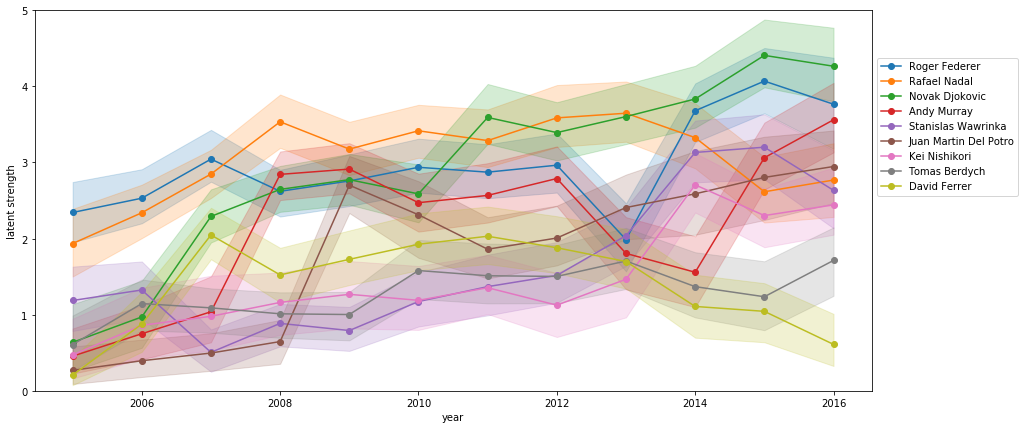

<Figure size 432x288 with 0 Axes>

In [144]:
plt.figure(figsize=(15,7))
cmap = matplotlib.cm.get_cmap('tab10')

for player in arr_target_player:

    samples = la['mu'][:, dic_target_player[player]-1, :]
    
    medians = np.median(samples, axis=0)
    lower, upper = np.percentile(samples, q=[25.0, 75.0], axis=0)
    
    plt.plot(arr_target_year, medians, marker='o', label=player, color=cmap(dic_target_player[player]-1))
    plt.fill_between(arr_target_year, lower, upper, alpha=0.2, color=cmap(dic_target_player[player]-1))
    
plt.xlabel('year')
plt.ylabel('latent strength')
plt.ylim([0,5])
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.savefig('./graphs/strength_ts_mu.png', bbox_inches='tight')

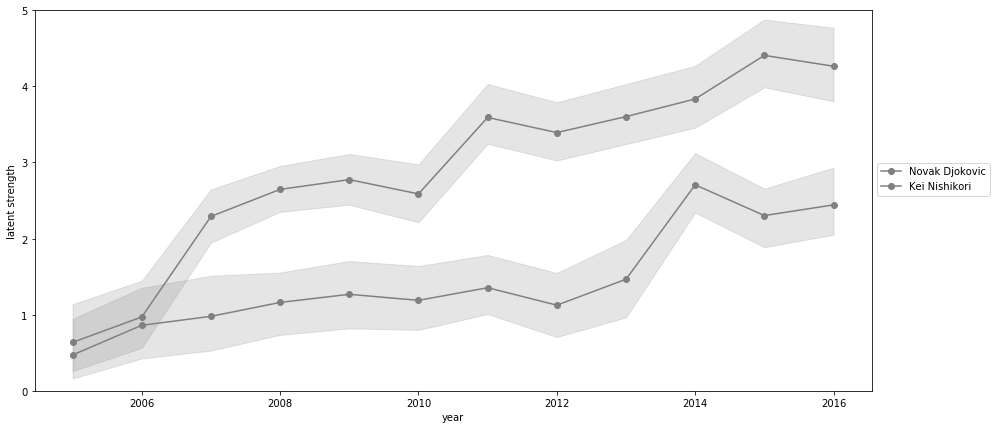

<Figure size 432x288 with 0 Axes>

In [150]:
plt.figure(figsize=(15,7))

linestyles = []

for player in ['Novak Djokovic', 'Kei Nishikori']:
    
    samples = la['mu'][:, dic_target_player[player]-1, :]
    
    medians = np.median(samples, axis=0)
    lower, upper = np.percentile(samples, q=[25.0, 75.0], axis=0)
    
    plt.plot(arr_target_year, medians, marker='o', label=player, color='gray')
    plt.fill_between(arr_target_year, lower, upper, alpha=0.2, color='gray')
    
plt.xlabel('year')
plt.ylabel('latent strength')
plt.ylim([0,5])
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.savefig('./graphs/strength_ts_mu_2.png', bbox_inches='tight')

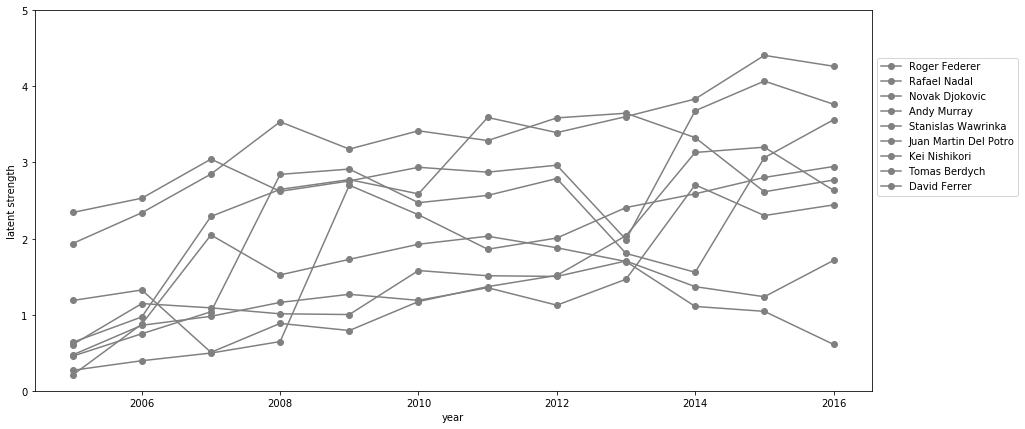

<Figure size 432x288 with 0 Axes>

In [152]:
plt.figure(figsize=(15,7))

for player in arr_target_player:

    samples = la['mu'][:, dic_target_player[player]-1, :]
    
    medians = np.median(samples, axis=0)
    
    plt.plot(arr_target_year, medians, marker='o', label=player, color='gray')
    
plt.xlabel('year')
plt.ylabel('latent strength')
plt.ylim([0,5])
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.savefig('./graphs/strength_ts_mu_noci.png', bbox_inches='tight')

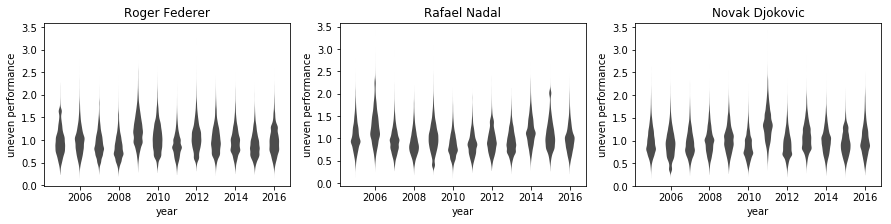

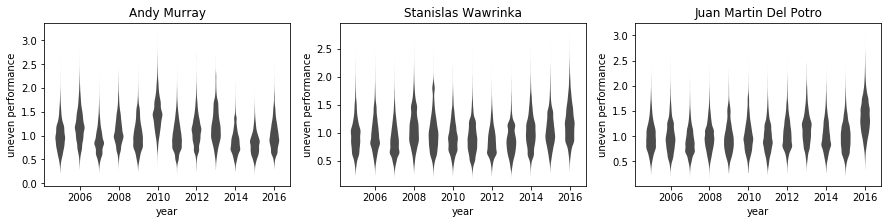

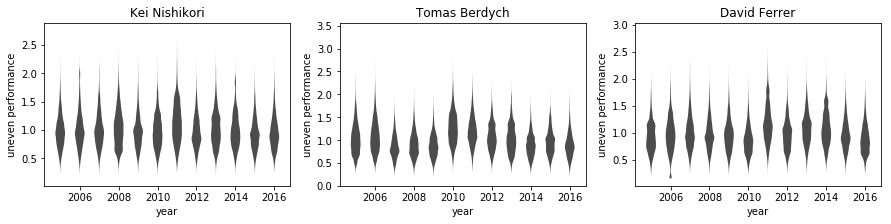

<Figure size 432x288 with 0 Axes>

In [154]:
for i, player in enumerate(arr_target_player):
    
    if i % 3 == 0:
        fig, axs = plt.subplots(ncols=3, figsize=(15, 3))
        
    g = axs[j%3].violinplot(la['s_pf'][:, i, :], positions=arr_target_year, showmeans=False, showextrema=False, showmedians=False)
    
    for pc in g['bodies']:
        pc.set_facecolor('black')
        pc.set_alpha(0.7)
        
    axs[i%3].set(title=player, xlabel='year', ylabel='uneven performance')
    
plt.show()
plt.savefig('./graphs/strength_ts_s_pf.png', bbox_inches='tight')

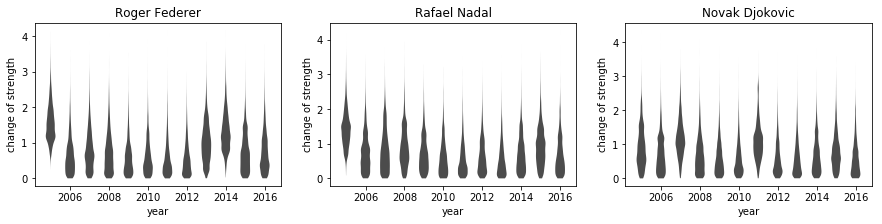

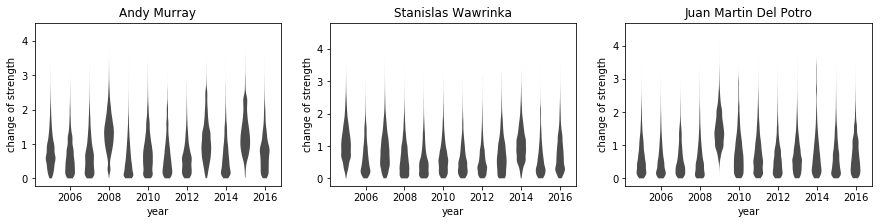

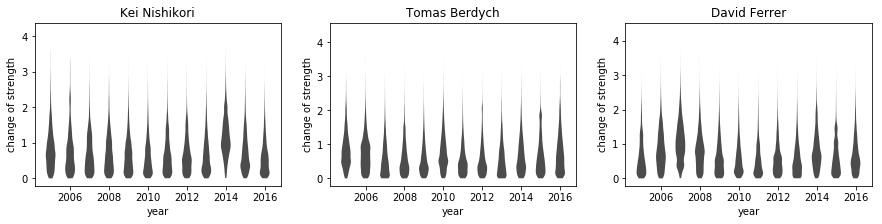

<Figure size 432x288 with 0 Axes>

In [155]:
for i, player in enumerate(arr_target_player):
    
    if i % 3 == 0:
        fig, axs = plt.subplots(ncols=3, figsize=(15, 3))
        
    g = axs[j%3].violinplot(la['s_mu'][:, i, :], positions=arr_target_year, showmeans=False, showextrema=False, showmedians=False)
    
    for pc in g['bodies']:
        pc.set_facecolor('black')
        pc.set_alpha(0.7)
        
    axs[i%3].set(title=player, xlabel='year', ylabel='change of strength')
    
plt.show()
plt.savefig('./graphs/strength_ts_s_mu.png', bbox_inches='tight')

# 前処理

In [2]:
%time !python preprocess.py > /dev/null

CPU times: user 0 ns, sys: 30 ms, total: 30 ms
Wall time: 1.21 s


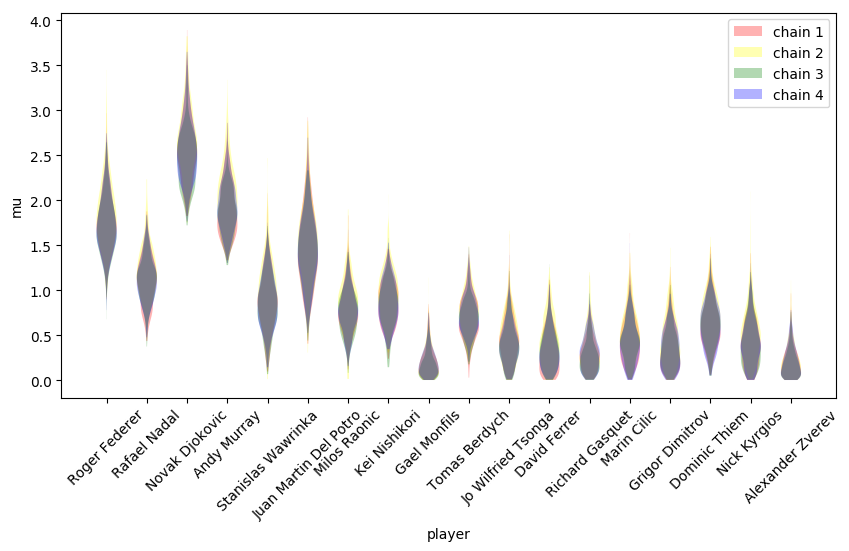

In [4]:
display_png(Image('./graphs/strength_mu_chains.png'))

In [1]:
import numpy as np                                                                                                                                                                                                                                                                
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
import pystan
#import imgkit
import pickle

In [2]:
arr_target_player = np.array([
    'Roger Federer', 'Rafael Nadal', 'Novak Djokovic',
    'Andy Murray', 'Stanislas Wawrinka', 'Juan Martin Del Potro',
    'Kei Nishikori', 'Tomas Berdych', 'David Ferrer'
])

In [3]:
arr_target_year = np.array(list(range(2005, 2017))) # 2005--2016

In [4]:
df_matches = pd.read_csv('./df_matches.csv')

In [5]:
df_target = df_matches[
    (df_matches['date'] < '2017-03') 
]

In [6]:
dic_target_year = {}

for year in arr_target_year:
    if year not in dic_target_year:
        dic_target_year[year] = len(dic_target_year)+1

In [7]:
dic_target_player = {}

for player in arr_target_player:
    if player not in dic_target_player:
        dic_target_player[player] = len(dic_target_player)+1

In [8]:
LW = []
GY = []

for year in arr_target_year:
    for player_a in arr_target_player:
        for player_b in arr_target_player:
            
            df_tmp = df_target[
                (df_target['winner_name'] == player_a) &
                (df_target['loser_name'] == player_b)
            ]
            
            for _ in range(len(df_tmp)):
                
                LW.append([dic_target_player[player_b], dic_target_player[player_a]])
                GY.append(dic_target_year[year])
                
            df_tmp = df_target[
                (df_target['winner_name'] == player_b) &
                (df_target['loser_name'] == player_a)
            ]
            
            for _ in range(len(df_tmp)):
                
                LW.append([dic_target_player[player_a], dic_target_player[player_b]])
                GY.append(dic_target_year[year])

LW = np.array(LW, dtype=np.int32)
GY = np.array(GY, dtype=np.int32)

In [9]:
LW.shape, GY.shape

((16032, 2), (16032,))

In [54]:
data = {
    'N': len(dic_target_player),
    'G': len(LW),
    'Y': len(dic_target_year),
    'GY': GY,
    'LW': LW,
}

In [ ]:
sm = pystan.StanModel(file='./model_strength_ts.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fde0244bca0f1943eefeff1ca69001b0 NOW.


In [ ]:
#fit = sm.sampling(data=data, iter=5000, chains=4)
fit = sm.vb(data=data, iter=10000)

In [ ]:
#la = fit.extract()

In [ ]:
vb_sample = pd.read_csv(fit['args']['sample_file'].decode('utf-8'), comment='#')
vb_sample = vb_sample.drop([0,1])

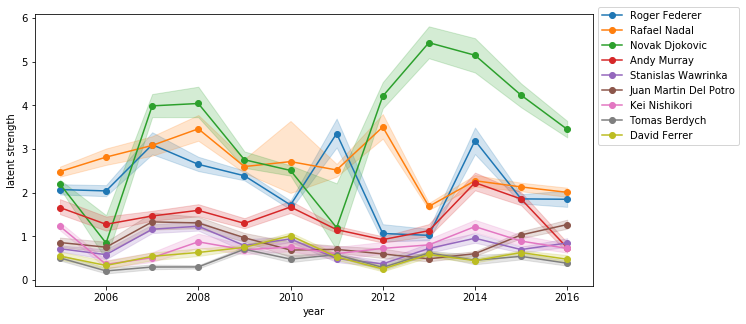

In [53]:
#la2 = fit

plt.figure(figsize=(10,5))
cmap = matplotlib.cm.get_cmap('tab10')

for j, player in enumerate(arr_target_player):

    #samples = la2['mu'][:, j, :]
    samples = []
    for y in range(len(arr_target_year)):
        s = vb_sample['mu.'+str(j+1)+'.'+str(y+1)].values
        samples.append(s)
    samples = np.array(samples).transpose()
    #print(samples.shape)
    
    #break
        
    
    medians = np.median(samples, axis=0)
    lower, upper = np.percentile(samples, q=[25.0, 75.0], axis=0)
    
    c = cmap(j)
    
    plt.plot(arr_target_year, medians, marker='o', label=player, color=c)
    plt.fill_between(arr_target_year, lower, upper, alpha=0.2, color=c)
    
plt.xlabel('year')
plt.ylabel('latent strength')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

In [48]:
samples = vb_sample['mu.'+(j+1)+'.'+(i+1)].values
samples.shape

(999,)

In [19]:
fit.keys()

odict_keys(['args', 'inits', 'sampler_params', 'sampler_param_names', 'mean_pars', 'mean_par_names'])

In [21]:
type(fit['args'])

dict

In [25]:
fit['args']['sample_file']

b'/tmp/tmpr85wkhph/output.csv'

In [26]:
!python --version

Python 3.6.7


In [24]:
fit['inits'][:10]

[-0.2351665479244307,
 0.42452602670958184,
 -1.3334734415070693,
 -0.7591471827061185,
 -0.17302110925308223,
 -0.2663382510212666,
 -1.9013966636360218,
 -1.9844276842944235,
 -0.39725064400749077,
 -1.347182504766479]

In [18]:
fit['sampler_param_names']

['performance[1,1]',
 'performance[2,1]',
 'performance[3,1]',
 'performance[4,1]',
 'performance[5,1]',
 'performance[6,1]',
 'performance[7,1]',
 'performance[8,1]',
 'performance[9,1]',
 'performance[10,1]',
 'performance[11,1]',
 'performance[12,1]',
 'performance[13,1]',
 'performance[14,1]',
 'performance[15,1]',
 'performance[16,1]',
 'performance[17,1]',
 'performance[18,1]',
 'performance[19,1]',
 'performance[20,1]',
 'performance[21,1]',
 'performance[22,1]',
 'performance[23,1]',
 'performance[24,1]',
 'performance[25,1]',
 'performance[26,1]',
 'performance[27,1]',
 'performance[28,1]',
 'performance[29,1]',
 'performance[30,1]',
 'performance[31,1]',
 'performance[32,1]',
 'performance[33,1]',
 'performance[34,1]',
 'performance[35,1]',
 'performance[36,1]',
 'performance[37,1]',
 'performance[38,1]',
 'performance[39,1]',
 'performance[40,1]',
 'performance[41,1]',
 'performance[42,1]',
 'performance[43,1]',
 'performance[44,1]',
 'performance[45,1]',
 'performance[46,1]